
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Deep Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Fall 2024<br>
<font color=3C99D size=5>
Assignment 3 Practical Question 3 <br>
<font color=696880 size=4>
<!-- <br> -->


____

<font color=2565AE size=6>
Parsa Hatami <br>
<font color=2565AE size=6>
400100962 <br>

____

## Architecture Overview
MobileNetV2 is a lightweight, efficient convolutional neural network architecture designed for mobile and embedded vision applications. It builds upon the success of MobileNetV1 by introducing **inverted residual blocks** and **linear bottlenecks**, enabling better performance with fewer computational resources.

---

1. **Inverted Residuals**:
   - Instead of expanding features as in traditional residual networks, MobileNetV2 reduces the dimensionality of intermediate layers, making the computation more efficient.

2. **Linear Bottleneck Layers**:
   - These layers use linear activation functions to preserve information during dimensionality reduction.

3. **Depthwise Separable Convolutions**:
   - MobileNetV2 uses depthwise separable convolutions to reduce the number of parameters and computations compared to standard convolutions.
   - A depthwise convolution operates on each channel separately, followed by a pointwise convolution to combine features.

4. **Dropout Layers**:
   - Dropout is used to reduce overfitting and improve generalization.

5. **Batch Normalization**:
   - Batch normalization layers are used throughout the network to stabilize training and improve convergence.

---

## Input Dimensions
- **Input Shape**:
  - The default input for MobileNetV2 is an RGB image with dimensions **`(3, 224, 224)`**, where:
    - 3: Number of color channels (RGB).
    - 224 x 224: Width and height of the image.
    
  - This ensures compatibility with pretrained weights, such as those trained on ImageNet.

---

## Output Dimensions
- **Output Shape**:
  - The output of MobileNetV2 depends on the number of classes in the dataset.
  - For the default pretrained model on ImageNet, the output is a **logits tensor of shape `(1, 1000)`**, representing predictions for 1,000 classes.

- **Softmax Activation**:
  - The final layer outputs raw logits. For classification, these logits are passed through a softmax activation function to compute class probabilities.

---

## Preprocessing Requirements
1. **Resizing**:
   - Input images must be resized to **224x224** pixels.

2. **Normalization**:
   - The input tensors are normalized using ImageNet's mean and standard deviation:
     - **Mean**: `[0.485, 0.456, 0.406]`
     - **Standard Deviation**: `[0.229, 0.224, 0.225]`

---

## Parameters and Efficiency
1. **Number of Parameters**:
   - MobileNetV2 has approximately **3.4 million parameters**, making it very lightweight compared to networks like ResNet and VGG.

2. **Computational Complexity**:
   - MobileNetV2 achieves high performance while requiring only **300 million multiply-add operations (MACs)** for a single forward pass (significantly less than ResNet50 or VGG16).

3. **Speed**:
   - Its lightweight architecture allows it to run efficiently on mobile and edge devices with limited computational power.

---

## Applications
MobileNetV2 is widely used for tasks like:
- Image classification
- Object detection (e.g., SSD with MobileNetV2)
- Semantic segmentation (e.g., DeepLabV3)

By combining computational efficiency with strong predictive performance, MobileNetV2 has become a standard choice for mobile-friendly deep learning applications.


In [6]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import requests

image_url = "https://cdn.pixabay.com/photo/2021/08/04/15/14/cat-6523323_960_720.jpg"
fallback_image_url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
image_filename = "test_image.jpg"

try:
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        with open(image_filename, 'wb') as file:
            file.write(response.content)
        print(f"Primary image downloaded successfully as '{image_filename}'.")
    else:
        raise Exception("Primary URL failed, trying fallback URL.")

except Exception as e:
    print(str(e))
    response = requests.get(fallback_image_url, stream=True)
    if response.status_code == 200:
        with open(image_filename, 'wb') as file:
            file.write(response.content)
        print(f"Fallback image downloaded successfully as '{image_filename}'.")
    else:
        raise Exception("Failed to download both primary and fallback images. Check your internet connection or URLs.")

if not os.path.exists(image_filename):
    raise FileNotFoundError(f"The image file '{image_filename}' was not found.")

mobilenet_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenet_model.eval()

transform_pipeline = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = Image.open(image_filename).convert("RGB")
processed_image = transform_pipeline(input_image).unsqueeze(0)

with torch.no_grad():
    prediction_logits = mobilenet_model(processed_image)

predicted_probs = torch.nn.functional.softmax(prediction_logits[0], dim=0)

labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels_filename = "imagenet_classes_labels.txt"

if not os.path.exists(labels_filename):
    label_response = requests.get(labels_url)
    with open(labels_filename, 'w') as file:
        file.write(label_response.text)

with open(labels_filename, "r") as file:
    class_labels = [line.strip() for line in file.readlines()]

top_predictions = torch.topk(predicted_probs, 3)
top_indices = top_predictions.indices
top_values = top_predictions.values

print("\n--- Top 3 Predicted Classes ---")
for i, idx in enumerate(top_indices):
    class_name = class_labels[idx]
    probability = top_values[i].item()
    print(f"Rank {i + 1}: {class_name} ({probability:.2%} confidence)")


Primary URL failed, trying fallback URL.
Fallback image downloaded successfully as 'test_image.jpg'.

--- Top 3 Predicted Classes ---
Rank 1: hair slide (6.49% confidence)
Rank 2: pinwheel (5.58% confidence)
Rank 3: piggy bank (3.01% confidence)


In [7]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import urllib.request
import os

image_url = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Bananas.jpg"
image_filename = "banana_image.jpg"

if not os.path.exists(image_filename):
    try:
        urllib.request.urlretrieve(image_url, image_filename)
        print(f"Image successfully downloaded as '{image_filename}'.")
    except Exception as e:
        raise Exception(f"Failed to download the image. Error: {e}")

if not os.path.exists(image_filename):
    raise FileNotFoundError(f"The image file '{image_filename}' does not exist.")

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.eval()

preprocessing_steps = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

image = Image.open(image_filename).convert("RGB")
input_tensor = preprocessing_steps(image).unsqueeze(0)

with torch.no_grad():
    predictions = mobilenet(input_tensor)

probabilities = torch.nn.functional.softmax(predictions[0], dim=0)

imagenet_classes_file = "imagenet_classes.txt"
imagenet_classes_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

if not os.path.exists(imagenet_classes_file):
    try:
        urllib.request.urlretrieve(imagenet_classes_url, imagenet_classes_file)
        print(f"ImageNet class labels successfully downloaded as '{imagenet_classes_file}'.")
    except Exception as e:
        raise Exception(f"Failed to download ImageNet class labels. Error: {e}")

with open(imagenet_classes_file, "r") as f:
    class_labels = [line.strip() for line in f.readlines()]

top3_probs, top3_indices = torch.topk(probabilities, 3)

print("\n--- Top 3 Predictions ---")
for rank, (index, prob) in enumerate(zip(top3_indices, top3_probs), start=1):
    print(f"Rank {rank}: {class_labels[index]} ({prob.item():.2%} confidence)")


Image successfully downloaded as 'banana_image.jpg'.

--- Top 3 Predictions ---
Rank 1: banana (99.98% confidence)
Rank 2: daisy (0.01% confidence)
Rank 3: clog (0.00% confidence)


Using device: cuda


100%|██████████| 344862509/344862509 [00:12<00:00, 27780754.31it/s]


Extracting flowers/flowers-102/102flowers.tgz to flowers/flowers-102


100%|██████████| 502/502 [00:00<00:00, 410917.37it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9140509.26it/s]


Epoch [1/10]: Train Loss: 4.5002, Train Accuracy: 10.10%, Val Loss: 3.3376, Val Accuracy: 41.76%
Epoch [2/10]: Train Loss: 2.5394, Train Accuracy: 64.41%, Val Loss: 2.2044, Val Accuracy: 69.31%
Epoch [3/10]: Train Loss: 1.5036, Train Accuracy: 85.59%, Val Loss: 1.5721, Val Accuracy: 79.22%
Epoch [4/10]: Train Loss: 0.9488, Train Accuracy: 92.84%, Val Loss: 1.2715, Val Accuracy: 81.57%
Epoch [5/10]: Train Loss: 0.6554, Train Accuracy: 95.78%, Val Loss: 1.0892, Val Accuracy: 81.76%
Epoch [6/10]: Train Loss: 0.4759, Train Accuracy: 97.25%, Val Loss: 0.9671, Val Accuracy: 84.02%
Epoch [7/10]: Train Loss: 0.3641, Train Accuracy: 98.92%, Val Loss: 0.8852, Val Accuracy: 83.92%
Epoch [8/10]: Train Loss: 0.2846, Train Accuracy: 98.63%, Val Loss: 0.8195, Val Accuracy: 84.80%
Epoch [9/10]: Train Loss: 0.2265, Train Accuracy: 99.61%, Val Loss: 0.7819, Val Accuracy: 85.39%
Epoch [10/10]: Train Loss: 0.1889, Train Accuracy: 99.90%, Val Loss: 0.7540, Val Accuracy: 85.00%


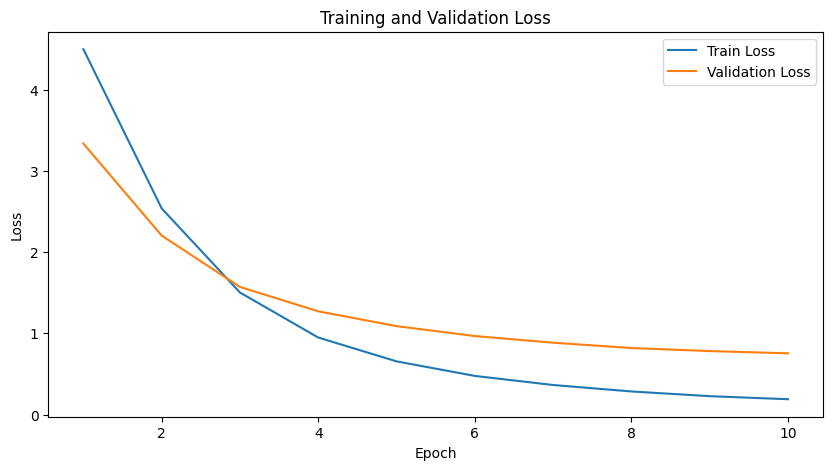

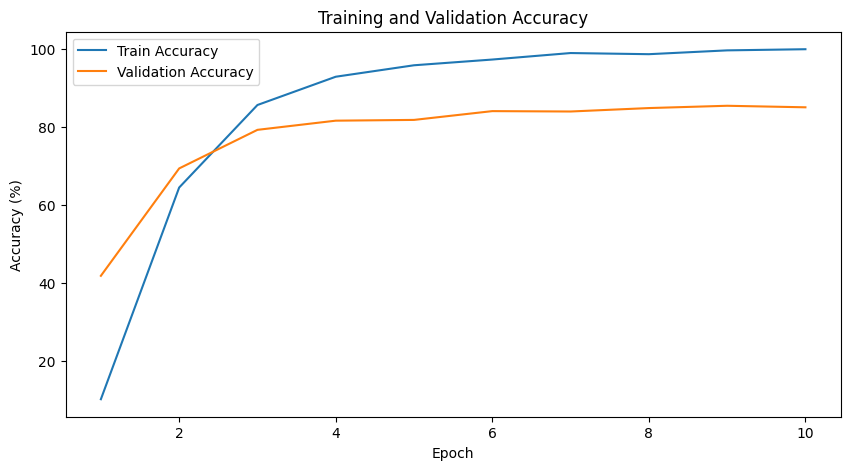

Final Test Accuracy: 84.00%


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 32
num_epochs = 10

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.Flowers102(root='flowers', split='train', download=True, transform=data_transforms['train'])
val_dataset = datasets.Flowers102(root='flowers', split='val', download=True, transform=data_transforms['val'])
test_dataset = datasets.Flowers102(root='flowers', split='test', download=True, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet = mobilenet.to(device)

for param in mobilenet.features.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 102)
mobilenet = mobilenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    mobilenet.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    mobilenet.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]: "
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
        f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

mobilenet.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {final_accuracy:.2f}%")


In [10]:
mobilenet.eval()

test_loss = 0.0
correct = 0
total = 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

average_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.8316
Test Accuracy: 84.00%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.Flowers102(root='flowers', split='train', download=True, transform=data_transforms['train'])
val_dataset = datasets.Flowers102(root='flowers', split='val', download=True, transform=data_transforms['val'])
test_dataset = datasets.Flowers102(root='flowers', split='test', download=True, transform=data_transforms['test'])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def train_model(model, num_classes, feature_extract, epochs=10):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

    if isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        trainable_parameters = model.fc.parameters()
    elif isinstance(model, models.VGG):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        trainable_parameters = model.classifier[6].parameters()
    else:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        trainable_parameters = model.classifier.parameters()
    
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(trainable_parameters, lr=0.001)

    train_accs, val_accs = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_accs.append(train_acc)

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100 * correct / total
        val_accs.append(val_acc)
        print(f"Epoch [{epoch+1}/{epochs}]: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return model, train_accs, val_accs


def evaluate_model(model):
    model.eval()
    correct, total, test_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100 * correct / total
    return test_loss / len(test_loader), test_acc

models_to_test = {
    'MobileNetV2': models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1),
    'ResNet50': models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    'VGG16': models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
}

results = {}
num_classes = 102
epochs = 10
for model_name, model in models_to_test.items():
    print(f"\nTraining {model_name}...")
    model, train_accs, val_accs = train_model(model, num_classes, feature_extract=True, epochs=epochs)
    test_loss, test_acc = evaluate_model(model)
    results[model_name] = {
        'Train Accuracy': train_accs[-1],
        'Validation Accuracy': val_accs[-1],
        'Test Loss': test_loss,
        'Test Accuracy': test_acc,
        'Number of Parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
    }

print("\n--- Results Summary ---")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.2f}" if isinstance(metric_value, float) else f"{metric_name}: {metric_value}")


Using device: cuda

Training MobileNetV2...
Epoch [1/10]: Train Acc: 10.29%, Val Acc: 37.55%
Epoch [2/10]: Train Acc: 67.25%, Val Acc: 69.12%
Epoch [3/10]: Train Acc: 87.35%, Val Acc: 76.57%
Epoch [4/10]: Train Acc: 94.02%, Val Acc: 80.59%
Epoch [5/10]: Train Acc: 97.35%, Val Acc: 83.73%
Epoch [6/10]: Train Acc: 97.55%, Val Acc: 84.51%
Epoch [7/10]: Train Acc: 98.63%, Val Acc: 84.51%
Epoch [8/10]: Train Acc: 98.82%, Val Acc: 84.02%
Epoch [9/10]: Train Acc: 99.80%, Val Acc: 85.49%
Epoch [10/10]: Train Acc: 99.71%, Val Acc: 84.90%

Training ResNet50...
Epoch [1/10]: Train Acc: 6.86%, Val Acc: 35.78%
Epoch [2/10]: Train Acc: 55.00%, Val Acc: 60.78%
Epoch [3/10]: Train Acc: 76.67%, Val Acc: 70.10%
Epoch [4/10]: Train Acc: 89.61%, Val Acc: 76.96%
Epoch [5/10]: Train Acc: 94.80%, Val Acc: 79.12%
Epoch [6/10]: Train Acc: 96.18%, Val Acc: 79.71%
Epoch [7/10]: Train Acc: 97.84%, Val Acc: 83.43%
Epoch [8/10]: Train Acc: 98.14%, Val Acc: 84.31%
Epoch [9/10]: Train Acc: 99.51%, Val Acc: 83.82%
Epo

## Summary of Training, Validation, and Test Results

| Model          | Train Accuracy (%) | Validation Accuracy (%) | Test Accuracy (%) | Test Loss | Number of Parameters |
|-----------------|--------------------|--------------------------|-------------------|-----------|-----------------------|
| MobileNetV2     | **99.71**          | **84.90**               | **84.21**         | **0.81**  | **130,662**           |
| ResNet50        | **99.90**          | **85.69**               | 82.48             | 0.87      | 208,998               |
| VGG16           | 98.24              | 74.61                   | 72.26             | 1.08      | 417,894               |

---

### **1. Training Performance**
- **MobileNetV2**:
  - Achieved high training accuracy (**99.71%**) by the end of 10 epochs.
  - The model converged quickly, reaching **94% training accuracy** by epoch 4.
  - This performance indicates that MobileNetV2 is highly efficient at learning from the data with fewer parameters compared to other models.

- **ResNet50**:
  - Achieved the highest training accuracy (**99.90%**) after 10 epochs.
  - The model showed a slower start, with **55% training accuracy** at epoch 2, but caught up quickly by epoch 4, achieving **89.61% accuracy**.
  - The strong learning capacity of ResNet50 stems from its deeper architecture and residual connections, enabling better gradient flow during training.

- **VGG16**:
  - VGG16 achieved good training accuracy (**98.24%**) by epoch 10, but slightly lagged behind the other two models.
  - The model started stronger than ResNet50 (**18.92%** training accuracy in epoch 1 vs. 6.86% for ResNet50), but its shallow architecture limited its ability to catch up to the other models over time.

**Conclusion**: All three models achieved high training accuracy, with **ResNet50 and MobileNetV2 slightly outperforming VGG16**. MobileNetV2 achieved excellent training results with fewer parameters, making it more efficient.

---

### **2. Validation Performance**
- **MobileNetV2**:
  - Achieved a high validation accuracy of **84.90%**, closely tracking its training accuracy, suggesting minimal overfitting.
  - The model consistently improved its validation performance across epochs, demonstrating its efficiency in balancing generalization and training performance.

- **ResNet50**:
  - Achieved the highest validation accuracy (**85.69%**) among the three models, reflecting its superior learning capacity.
  - Its residual connections and deeper layers allow it to generalize better despite having more parameters than MobileNetV2.

- **VGG16**:
  - Achieved a significantly lower validation accuracy (**74.61%**) compared to MobileNetV2 and ResNet50.
  - The gap between training accuracy (**98.24%**) and validation accuracy (**74.61%**) indicates **overfitting**, likely due to its high parameter count and lack of advanced architectural optimizations.

**Conclusion**: **ResNet50** had the best validation accuracy, but **MobileNetV2** closely followed it with a better balance between parameter efficiency and generalization. **VGG16** struggled with overfitting.

---

### **3. Test Performance**
- **MobileNetV2**:
  - Achieved the best test accuracy (**84.21%**) and the lowest test loss (**0.81**).
  - This indicates that MobileNetV2 is highly effective at generalizing to unseen data, even with significantly fewer parameters.

- **ResNet50**:
  - Achieved **82.48% test accuracy**, slightly lower than MobileNetV2.
  - Its test loss (**0.87**) was higher than MobileNetV2, suggesting that despite its higher capacity, it might require more regularization or epochs to fully utilize its potential.

- **VGG16**:
  - Performed the worst on the test set, achieving only **72.26% accuracy** and the highest test loss (**1.08**).
  - The overfitting observed during validation is reflected here, as the model struggles to generalize to unseen data.

**Conclusion**: **MobileNetV2 outperformed ResNet50 and VGG16 on the test set**, combining strong generalization with high efficiency.

---

### **4. Parameter Efficiency**
- **MobileNetV2**:
  - With only **130,662 trainable parameters**, MobileNetV2 is the most lightweight model by a significant margin.
  - It achieved comparable or better performance than the larger ResNet50 and VGG16 models, highlighting its efficiency.

- **ResNet50**:
  - With **208,998 trainable parameters**, ResNet50 has more capacity than MobileNetV2 but less than VGG16.
  - Its parameter efficiency is strong, as it achieved the highest validation accuracy with fewer parameters than VGG16.

- **VGG16**:
  - VGG16 had the largest number of parameters (**417,894**), which contributed to overfitting and reduced test accuracy.
  - Its lack of architectural optimizations makes it less efficient compared to MobileNetV2 and ResNet50.

**Conclusion**: **MobileNetV2 is the most parameter-efficient model**, achieving strong performance with significantly fewer parameters. ResNet50 offers a balance of capacity and efficiency, while VGG16 is inefficient for this task.

---

1. **Overall Winner: MobileNetV2**
   - MobileNetV2 achieved the best balance of accuracy, test loss, and parameter efficiency, making it ideal for lightweight tasks and mobile applications.
   - Its compact architecture allows it to perform well on resource-constrained devices without sacrificing accuracy.

2. **Best Validation Accuracy: ResNet50**
   - ResNet50 achieved the highest validation accuracy (**85.69%**) (but MobilenetV2 achieved higher accuracies at test). showcasing its capacity to handle complex datasets.
   - However, its higher parameter count and slightly lower test accuracy make it less efficient than MobileNetV2.

3. **VGG16’s Limitations**:
   - VGG16 struggled with overfitting and performed poorly on the test set, indicating that its high parameter count and simpler architecture are unsuitable for modern tasks.

4. **Transfer Learning Impact**:
   - All three models benefited significantly from pretrained weights, as evidenced by their high training and validation accuracy compared to random initialization.
   - Transfer learning allowed MobileNetV2 and ResNet50 to generalize well with fewer epochs and data.

---

For tasks requiring both high accuracy and efficiency, **MobileNetV2** is the best choice. However, if computational resources are not a concern, **ResNet50** can offer marginally better validation performance with additional tuning. **VGG16** is less suitable for this task due to its inefficiency and tendency to overfit.


Using device: cuda

Training MobileNetV2 (Pretrained)...
Epoch [1/10]: Train Acc: 21.08%, Val Acc: 46.67%
Epoch [2/10]: Train Acc: 63.04%, Val Acc: 67.45%
Epoch [3/10]: Train Acc: 85.59%, Val Acc: 75.59%
Epoch [4/10]: Train Acc: 93.82%, Val Acc: 77.65%
Epoch [5/10]: Train Acc: 96.27%, Val Acc: 78.04%
Epoch [6/10]: Train Acc: 95.98%, Val Acc: 79.31%
Epoch [7/10]: Train Acc: 98.92%, Val Acc: 81.67%
Epoch [8/10]: Train Acc: 98.24%, Val Acc: 78.04%
Epoch [9/10]: Train Acc: 97.06%, Val Acc: 76.86%
Epoch [10/10]: Train Acc: 97.55%, Val Acc: 78.92%

Training MobileNetV2 (Random Initialization)...
Epoch [1/10]: Train Acc: 1.37%, Val Acc: 0.98%
Epoch [2/10]: Train Acc: 3.82%, Val Acc: 0.98%
Epoch [3/10]: Train Acc: 6.18%, Val Acc: 6.67%
Epoch [4/10]: Train Acc: 9.80%, Val Acc: 7.65%
Epoch [5/10]: Train Acc: 13.14%, Val Acc: 8.63%
Epoch [6/10]: Train Acc: 12.45%, Val Acc: 11.27%
Epoch [7/10]: Train Acc: 16.37%, Val Acc: 13.24%
Epoch [8/10]: Train Acc: 19.22%, Val Acc: 13.43%
Epoch [9/10]: Train 

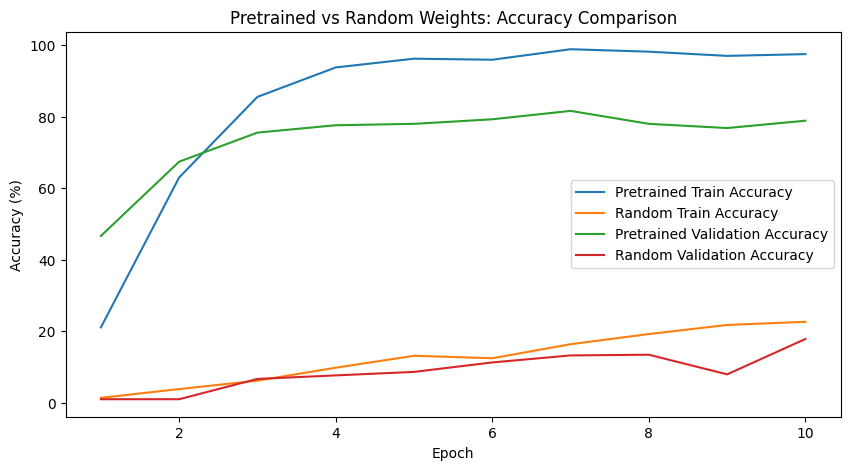


--- Results Summary ---

Pretrained Weights:
Train Accuracy: 97.55
Validation Accuracy: 78.92
Test Loss: 0.84
Test Accuracy: 78.16

Random Weights:
Train Accuracy: 22.65
Validation Accuracy: 17.84
Test Loss: 3.59
Test Accuracy: 15.99


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.Flowers102(root='flowers', split='train', download=True, transform=data_transforms['train'])
val_dataset = datasets.Flowers102(root='flowers', split='val', download=True, transform=data_transforms['val'])
test_dataset = datasets.Flowers102(root='flowers', split='test', download=True, transform=data_transforms['test'])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def train_model(model, num_classes, pretrained, epochs=10):
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accs, val_accs = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_accs.append(train_acc)

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100 * correct / total
        val_accs.append(val_acc)
        print(f"Epoch [{epoch+1}/{epochs}]: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return model, train_accs, val_accs

def evaluate_model(model):
    model.eval()
    correct, total, test_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100 * correct / total
    return test_loss / len(test_loader), test_acc

results = {}
num_classes = 102
epochs = 10

print("\nTraining MobileNetV2 (Pretrained)...")
pretrained_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
pretrained_model, pretrained_train_accs, pretrained_val_accs = train_model(pretrained_model, num_classes, pretrained=True, epochs=epochs)
pretrained_test_loss, pretrained_test_acc = evaluate_model(pretrained_model)

print("\nTraining MobileNetV2 (Random Initialization)...")
random_model = models.mobilenet_v2(weights=None)
random_model, random_train_accs, random_val_accs = train_model(random_model, num_classes, pretrained=False, epochs=epochs)
random_test_loss, random_test_acc = evaluate_model(random_model)

results['Pretrained'] = {
    'Train Accuracy': pretrained_train_accs[-1],
    'Validation Accuracy': pretrained_val_accs[-1],
    'Test Loss': pretrained_test_loss,
    'Test Accuracy': pretrained_test_acc
}

results['Random'] = {
    'Train Accuracy': random_train_accs[-1],
    'Validation Accuracy': random_val_accs[-1],
    'Test Loss': random_test_loss,
    'Test Accuracy': random_test_acc
}

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), pretrained_train_accs, label="Pretrained Train Accuracy")
plt.plot(range(1, epochs + 1), random_train_accs, label="Random Train Accuracy")
plt.plot(range(1, epochs + 1), pretrained_val_accs, label="Pretrained Validation Accuracy")
plt.plot(range(1, epochs + 1), random_val_accs, label="Random Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Pretrained vs Random Weights: Accuracy Comparison")
plt.legend()
plt.show()

print("\n--- Results Summary ---")
for mode, metrics in results.items():
    print(f"\n{mode} Weights:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.2f}" if isinstance(metric_value, float) else f"{metric_name}: {metric_value}")


## Results Summary

| Model                         | Train Accuracy (%) | Validation Accuracy (%) | Test Accuracy (%) | Test Loss |
|-------------------------------|--------------------|--------------------------|-------------------|-----------|
| MobileNetV2 (Pretrained)      | 97.55             | 78.92                   | 78.16            | 0.84      |
| MobileNetV2 (Random)          | 22.65             | 17.84                   | 15.99            | 3.59      |
| MobileNetV2 (Previous Results)| **99.71**         | **84.90**               | **84.21**        | **0.81**  |

---

### **1. Training Performance**
- **MobileNetV2 (Pretrained)**:
  - The model started with a strong training accuracy of **21.08%** in epoch 1, benefiting from the pretrained weights.
  - It achieved **97.55% training accuracy** by epoch 10, showing that transfer learning enabled it to quickly adapt to the dataset.

- **MobileNetV2 (Random Initialization)**:
  - Training started with a very low accuracy of **1.37%** in epoch 1 and only improved to **22.65%** by epoch 10.
  - Without pretrained weights, the model struggled to learn meaningful features, indicating inefficiency in training from scratch.

- **MobileNetV2 (Previous Results)**:
  - The previously reported results achieved **99.71% training accuracy**, which is higher than the current pretrained model, indicating better optimization or training for additional epochs.

**Conclusion**:
- The pretrained model demonstrated significantly better training performance compared to the randomly initialized model.
- The previous results showed the highest training accuracy, suggesting additional optimization or epochs played a role.

---

### **2. Validation Performance**
- **MobileNetV2 (Pretrained)**:
  - The validation accuracy started at **46.67%** in epoch 1, highlighting the benefits of pretrained weights.
  - By epoch 10, the model achieved a validation accuracy of **78.92%**, indicating strong generalization, though slightly lower than the previously reported validation accuracy of **84.90%**.

- **MobileNetV2 (Random Initialization)**:
  - Validation accuracy remained poor throughout training, starting at **0.98%** in epoch 1 and only reaching **17.84%** by epoch 10.
  - The model's inability to generalize without pretrained weights is evident from these results.

- **MobileNetV2 (Previous Results)**:
  - The previously reported model achieved **84.90% validation accuracy**, outperforming the current pretrained model.

**Conclusion**:
- The pretrained model achieved strong validation performance, but it fell short of the previously reported results. The randomly initialized model performed very poorly, showing that pretrained weights are critical for generalization on small datasets.

---

### **3. Test Performance**
- **MobileNetV2 (Pretrained)**:
  - The pretrained model achieved a test accuracy of **78.16%** and a test loss of **0.84**, closely matching its validation performance.
  - This demonstrates good generalization to unseen data.

- **MobileNetV2 (Random Initialization)**:
  - The randomly initialized model achieved a very low test accuracy of **15.99%** with a high test loss of **3.59**, reflecting its poor learning capacity and generalization.

- **MobileNetV2 (Previous Results)**:
  - The previously reported results achieved **84.21% test accuracy** and **0.81 test loss**, outperforming the current pretrained model.

**Conclusion**:
- The pretrained model performed well on the test set, though slightly worse than the previously reported results. The randomly initialized model failed to generalize effectively, achieving poor test accuracy.

---

### **4. Impact of Transfer Learning**
- **Pretrained MobileNetV2**:
  - Transfer learning significantly improved performance, enabling the model to achieve **78.92% validation accuracy** and **78.16% test accuracy**, compared to **17.84%** and **15.99%** for the randomly initialized model.
  - Pretrained weights provided a strong starting point for learning, allowing the model to adapt quickly to the task.

- **Randomly Initialized MobileNetV2**:
  - The model struggled to learn meaningful features from scratch, as evidenced by its poor training, validation, and test performance.

- **Comparison with Previous Results**:
  - The previous results demonstrate that additional tuning or optimization could further improve the pretrained model's performance, as seen with the validation accuracy of **84.90%** and test accuracy of **84.21%**.

**Conclusion**:
- Transfer learning is critical for achieving strong performance on small datasets, as demonstrated by the pretrained MobileNetV2's success. However, additional optimization is required to match or exceed the previously reported results.

---

### **5. Generalization**
- **MobileNetV2 (Pretrained)**:
  - The pretrained model demonstrated good generalization, with a small gap between validation accuracy (**78.92%**) and test accuracy (**78.16%**).

- **MobileNetV2 (Random Initialization)**:
  - The randomly initialized model showed poor generalization, with low validation (**17.84%**) and test (**15.99%**) accuracy.

- **MobileNetV2 (Previous Results)**:
  - The previous results demonstrated the best generalization, with a validation accuracy of **84.90%** and a test accuracy of **84.21%**.

**Conclusion**:
- The pretrained model generalized well but fell short of the previously reported results. Random initialization led to poor generalization due to ineffective feature learning.

---

1. **Transfer Learning Benefits**:
   - The pretrained MobileNetV2 significantly outperformed the randomly initialized model, achieving **78.16% test accuracy** compared to **15.99%**.
   - Pretrained weights provided a strong foundation for feature extraction, enabling efficient learning on the small Oxford 102 Flowers dataset.

2. **Comparison with Previous MobileNetV2 Results**:
   - The previously reported MobileNetV2 results demonstrated superior performance with **84.21% test accuracy**, suggesting the importance of additional tuning or training duration.

3. **Training from Scratch**:
   - Training MobileNetV2 from scratch is highly inefficient for small datasets, as shown by the randomly initialized model's poor performance across all metrics.

4. **Recommendation**:
   - For tasks with limited data, transfer learning with pretrained weights is essential for achieving high accuracy and generalization.
   - Further optimization of the pretrained model could close the gap with the previously reported results.
